<script>
    document.querySelector('head').innerHTML += '<style>.slides { zoom: 1. !important; }</style>';
</script>

# Week 9 - Tree-Based Methods
### Dr. David Elliott

1.1. [Introduction](#intro)

1.2. [Dataset Example: Penguins](#data1)

1.3. [General Decision Tree Algorithm](#gen)

1.4. [Dataset Example: X](#data2)

1.5. [Specific Decision Tree Algorithms](#spec)

# 1.1. Introduction <a id='intro'></a>

_Tree-based_ methods _stratify_ or _segment_ the predictor space into a number of simple regions<sup>1</sup>. As the spliting rules to make these decision regions can be summerised in a tree structure, these approaches are called _decision trees_.

A decision tree breaks data down by asking a series of questions in order to categorise samples into the same class. 

We will be looking at how we can use them alone as well as in ensembles.

__NOTES__

__Question:__ Why not just stick to decision trees? 

__Answer:__ Although they are useful for interpretation, they are not as competative for supervised learning methods, so we'll also talk about bagging, random forests, and boosting; which all rely on producing multiple trees and combining them to gain a single prediction. This typically improves accuracy a lot, but at the expense of interpretability.

__NOTES__

"_In the context of the different categories of machine learning algorithms that we defined at the beginning of this course, we may categorize decision trees as follows:_
- _Supervised learning algorithm: classification and regression_
- _Optimization method: combinatorial -> greedy search_
- _Eager learning algorithm_
- _Batch learning algorithm_
- _Nonparametric model_
- _Deterministic (vs. stochastic)_"


- Supervised learning algorithm:
- greedy search:
- Eager learning algorithm:
- Batch learning algorithm:
- Nonparametric model:
- Deterministic:


__TODO__
- in the notes explain what these are again.
- have a look through this: https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/Chapter%208.ipynb

---
https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__notes.pdf

__DESIGN PRINCIPLE__
- Start with image, then sudo-algorithm description, then stats!

__TODO__
- Pillage the notes of http://pages.stat.wisc.edu/~sraschka/teaching/stat479-fs2019/

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib
from IPython.display import Image
import os
from sklearn.model_selection import train_test_split

matplotlib.rcParams['animation.embed_limit'] = 30000000.0
#plt.rcParams['figure.dpi'] = 120

# colours for printing outputs
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
image_dir = os.path.join(os.getcwd(),"Images")
data_dir = os.path.join(os.getcwd(),"..","Data")

__TODO__
- Tidy below, maybe split it up thoughout the notebook

In [2]:
col_dict = {
    "Adelie":"#ff7600",
    "Chinstrap":"#c65dcb",
    "Gentoo":"#057576"}

shape_dict = {
    "Adelie":"o",
    "Chinstrap":"s",
    "Gentoo":"X"}

datasets = {}
penguins = sns.load_dataset("penguins")

# dropna
penguins_rm = penguins.dropna()

# keep categorical features
penguins_cat = penguins_rm[["island", "sex", "species"]]
penguins_bin = penguins_cat[penguins_cat.species != "Chinstrap"]
y_bin = penguins_bin[["species"]].replace({'Adelie': 0, 'Gentoo': 1}).values.flatten()
# for the classification data we don't want species there either
penguins_class_feat = penguins_bin.drop("species", axis=1)
datasets['cat'] = {"df":penguins_bin, 
                    "X": penguins_class_feat[["island", "sex"]].values,
                    "y": y_bin,
                    "feats": ["island", "sex"],
                     "class": ['Adelie', 'Gentoo']}


# drop continuous features
penguins_cont = penguins_rm.drop(["island", "sex", "species"], axis=1)

# for the regression data we don't want body_mass_g there either
penguins_reg_feat = penguins_cont.drop(["body_mass_g"], axis=1)

datasets['reg_full'] = {"df":penguins_cont, 
                        "X":penguins_reg_feat.values,
                        "y": penguins_rm[["body_mass_g"]].values.flatten(),
                        "feats": list(penguins_reg_feat.columns)}

# regression datset just to compare flipper length to body mass
datasets['flbm'] = {"df":penguins_cont, 
                    "X":penguins_reg_feat[["flipper_length_mm"]].values,
                    "y": penguins_rm[["body_mass_g"]].values.flatten(),
                    "feats": ["Flipper Length (mm)"]}

# make a binary classification dataset
penguins_class = penguins_rm.drop(["island", "sex"], axis=1)
# for the classification data we don't want species there either
penguins_class_feat = penguins_class.drop("species", axis=1)
y_multi = penguins_class[["species"]].replace({'Adelie': 0, 'Gentoo': 1, "Chinstrap":2}).values.flatten()

datasets['multi'] = {"df":penguins_class, 
                     "X": penguins_class_feat.values,
                     "y": y_multi,
                     "feats": list(penguins_class_feat.columns),
                     "class": ['Adelie', 'Gentoo', "Chinstrap"]}


penguins_bin = penguins_class[penguins_class.species != "Chinstrap"]
y_bin = penguins_bin[["species"]].replace({'Adelie': 0, 'Gentoo': 1}).values.flatten()
# for the classification data we don't want species there either
penguins_class_feat = penguins_bin.drop("species", axis=1)

datasets['bin'] = {"df":penguins_bin, 
                   "X": penguins_class_feat.values,
                   "y": y_bin,
                   "feats": list(penguins_class_feat.columns),
                   "class": ['Adelie', 'Gentoo']}

datasets['flbl'] = {"df":penguins_bin, 
                    "X": penguins_class_feat[["flipper_length_mm", "bill_length_mm"]].values,
                    "y": y_bin,
                    "feats": ["flipper_length_mm", "bill_length_mm"],
                     "class": ['Adelie', 'Gentoo']}

datasets['blbd'] = {"df":penguins_bin, 
                    "X": penguins_class_feat[["bill_length_mm", "bill_depth_mm"]].values,
                    "y": y_bin,
                    "feats": ["bill_length_mm", "bill_depth_mm"],
                    "class": ['Adelie', 'Gentoo']}

In [3]:
if os.path.exists(os.path.join(data_dir,"palmerpenguins")):
    print("Already Cloned")
else:
    import git
    git.Git(os.getcwd()).clone("https://github.com/allisonhorst/palmerpenguins.git")
    
penguins_fig_dir = os.path.join(data_dir,"palmerpenguins", "man", "figures")

Already Cloned


### __Terminology__<sup>5</sup>

__Root node:__ no incoming edge, zero, or more outgoing edges.

__Internal node:__ one incoming edge, two (or more) outgoing edges.

__Leaf node:__ each leaf node is assigned a class label if nodes are pure; otherwise, the class label is determined by majority vote.

__Parent and child nodes:__ If a node is split, we refer to that given node as the parent node, and the resulting nodes are called child nodes.

__TODO__
- Make your own diagram with "Global Pandemic?" as the second box. See if you can do this in a python package?

__Notes__
- Leaves are typically drawn upside down, so they are at the bottom of the tree

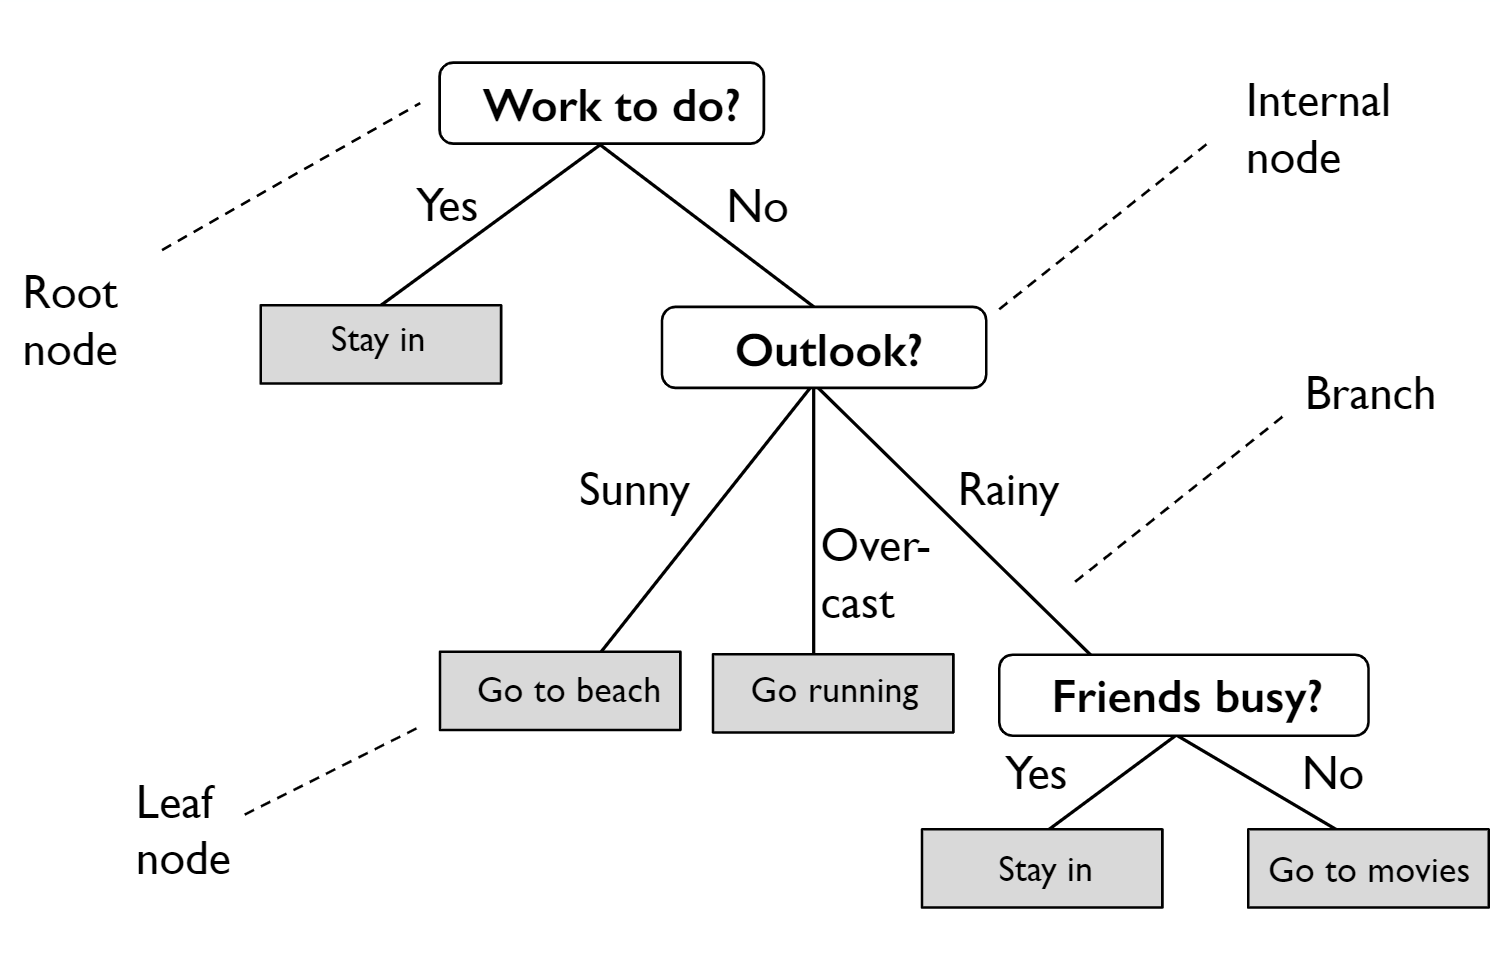

In [16]:
# taken from https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__slides.pdf
Image(os.path.join(image_dir, "tree_terms.png"), width=550)

# 1.2. Dataset Example: Penguins <a id='data1'></a>
The _"palmer penguins"_ dataset<sup>2</sup> contains data for 344 penguins from 3 different species and from 3 islands in the Palmer Archipelago, Antarctica.
___
Artwork by @allison_horst

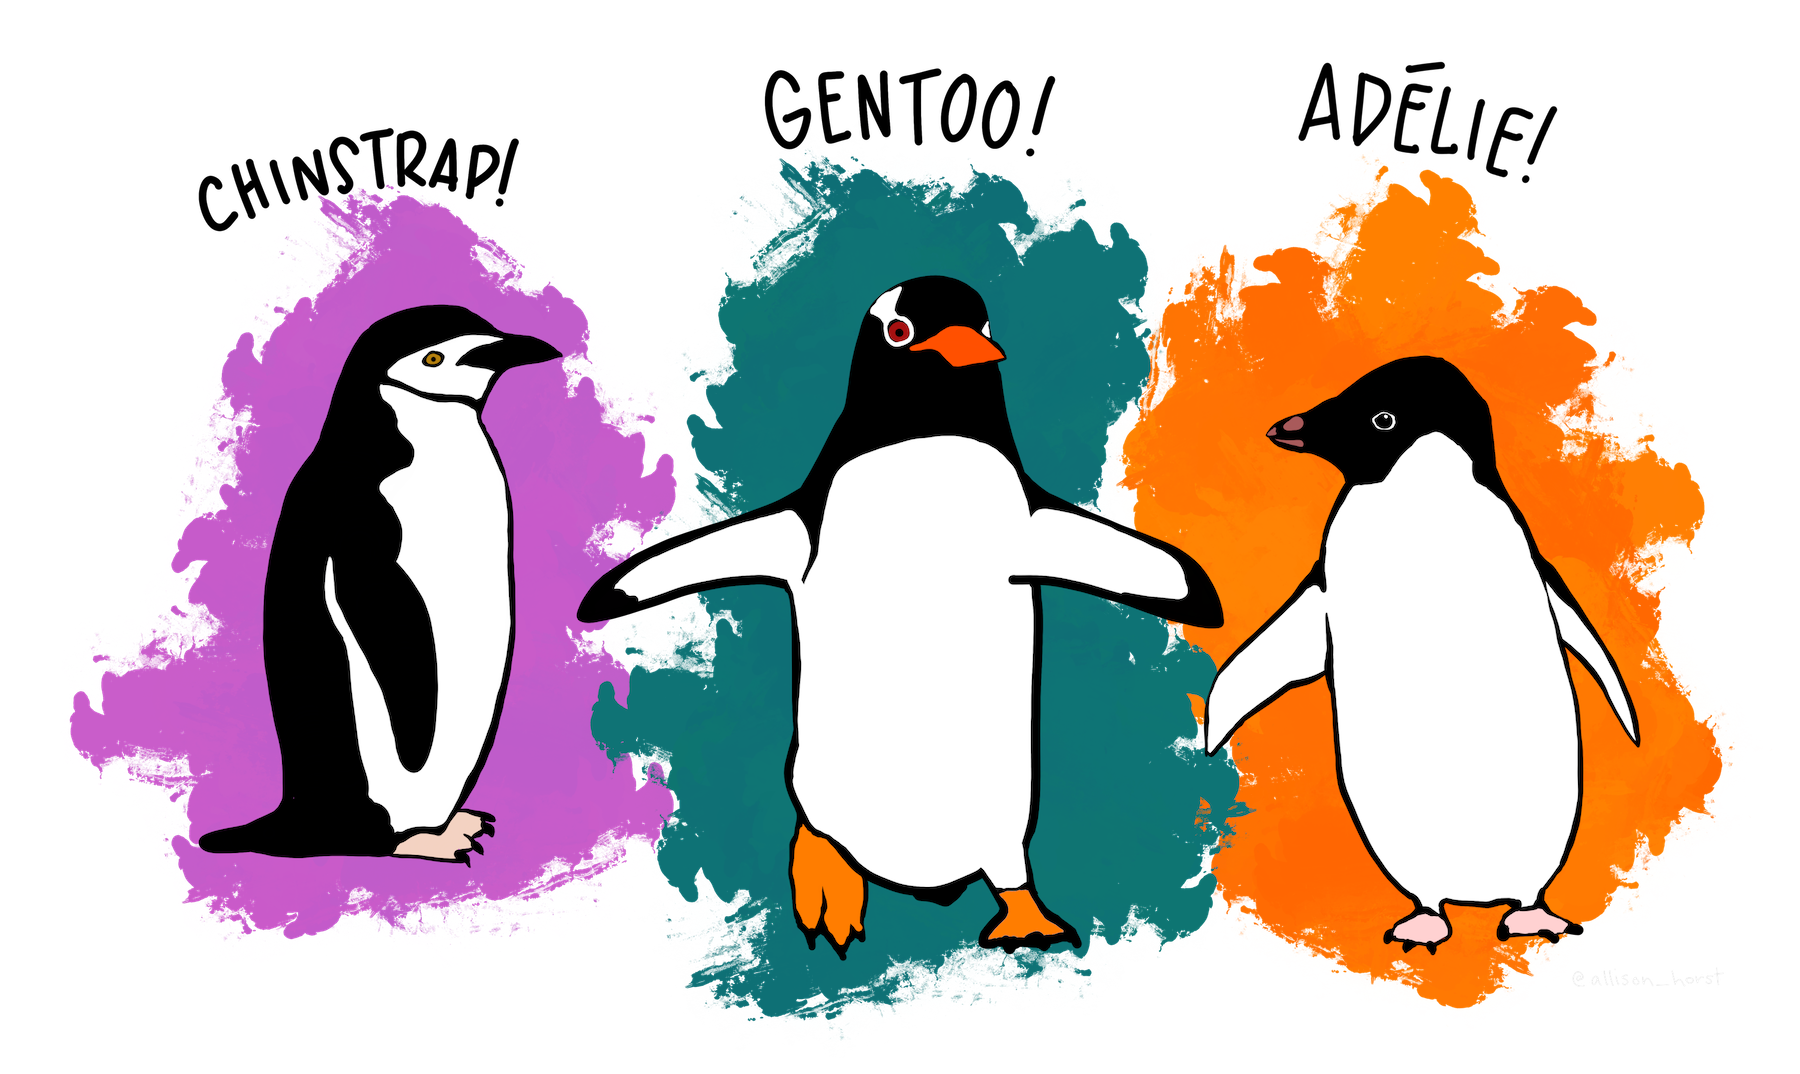

In [19]:
Image(os.path.join(penguins_fig_dir, "lter_penguins.png"), width=600)

In [6]:
display(penguins.head())

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female

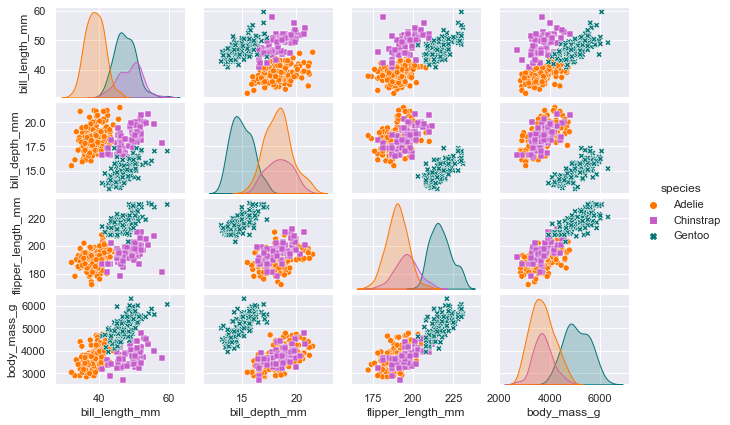

In [13]:
sns.pairplot(penguins, hue="species", markers=shape_dict, palette=col_dict, height=1.5, aspect = 1.5)
plt.show()

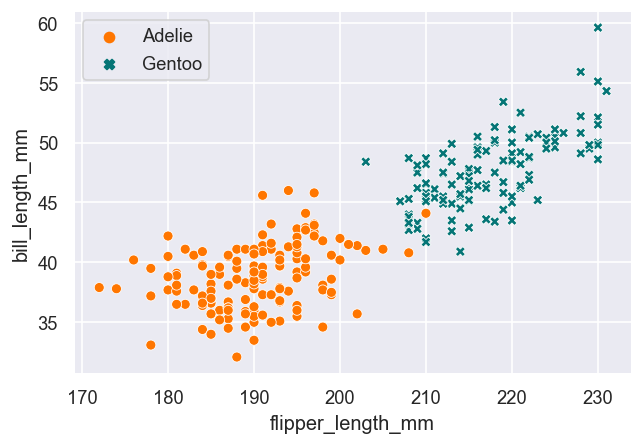

In [8]:
g = sns.scatterplot(data=datasets['flbl']['df'], x = "flipper_length_mm", 
                    y = "bill_length_mm", hue="species", style = "species",
                    markers = shape_dict,  palette= col_dict)
#plt.title("")
g.axes.get_legend().set_title(False)
plt.show()

# 1.3. General Decision Tree Algorithm <a id='gen'></a>

An algorithm starts at a tree root and then splits the data based on the features that give the best split based on a splitting criterion.

Generally this splitting procedure occours until all the samples within a given node all belong to the same class<sup>4</sup>, the maximum depth of the tree is reached, or a split cannot be found that improves the model<sup>3</sup>. 

__NOTES__
- The process of growing a decision tree can be expressed as a recursive algorithm as follows<sup>5</sup>:
    1. Pick a feature such that when parent node is split, it results in the largest information gain and stopping if information gain is not positive.
    2. Stop if child nodes are pure or no improvement in class purity can be made.
    3. Go back to step 1 for each of the two child nodes.

In [9]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn import tree

DT_g1 = DecisionTreeClassifier(criterion='gini',
                               max_depth = 1,
                               random_state=42)

l_labels = [[189, 57.5],[219, 57.5]]
r_labels = [[0.225, 0.4],[0.725, 0.4]]
tp_labels = [[0.28, 0.5],[0.64, 0.5]]

def regions_tree(DT, X, y, feature_names, class_names, l_label_pos=None, r_label_pos=None, tp_label_pos=None, impurity = False):
    DT.fit(X,y)

    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    plt.sca(axes[0])

    scatter_kwargs = {"c":col_dict, "marker":shape_dict}
    ax = plot_decision_regions(X, y, clf = DT,
                               markers = [shape_dict["Adelie"], shape_dict["Gentoo"]],
                               colors = col_dict["Adelie"]+","+col_dict["Gentoo"]
                              )

    handles, labels = ax.get_legend_handles_labels()
    
    if l_label_pos:
        plt.text(l_label_pos[0][0], l_label_pos[0][1], "$R_1$", bbox=dict(facecolor='white', alpha=0.3))
        plt.text(l_label_pos[1][0], l_label_pos[1][1], "$R_2$", bbox=dict(facecolor='white', alpha=0.3))
    
    ax.legend(handles, 
              class_names, 
              framealpha=0.3, scatterpoints=1)

    plt.xlabel(feature_names[0]) 
    plt.ylabel(feature_names[1])
    # The arrows dont show up on versions of Scikit Learn due to a weird interaction with sns 
    # so I need to use `plt.style.context("classic")`.
    with plt.style.context("classic"):
        plt.sca(axes[1])
        tp = tree.plot_tree(DT,
                       feature_names=feature_names, 
                       class_names=class_names,
                       filled = True,
                           impurity = impurity)
        if r_label_pos:
            axes[1].text(r_label_pos[0][0], r_label_pos[0][1],
                         "$R_1$")
            axes[1].text(r_label_pos[1][0], r_label_pos[1][1], 
                         "$R_2$")
            
        if tp_label_pos:
            axes[1].text(tp_label_pos[0][0], tp_label_pos[0][1],
                         "False", {'fontweight':'bold'})
            axes[1].text(tp_label_pos[1][0], tp_label_pos[1][1], 
                         "True", {'fontweight':'bold'})
        
        tp[1].set_backgroundcolor(col_dict["Adelie"])
        tp[2].set_backgroundcolor(col_dict["Gentoo"])

    plt.show()

Below is an example of a very shallow decision tree where we have set `max_depth = 1`.

__Terminology (Reminder)__<sup>1</sup>
- The regions $R_1$ and $R_2$ are known as _terminal nodes_ or _leaves_ of the tree.
- The points where the predictor space is split are known as the _internal nodes_. In this case as we only have one split this is the  _"root node"_.
- The segments of the trees that connect the nodes are _branches_.

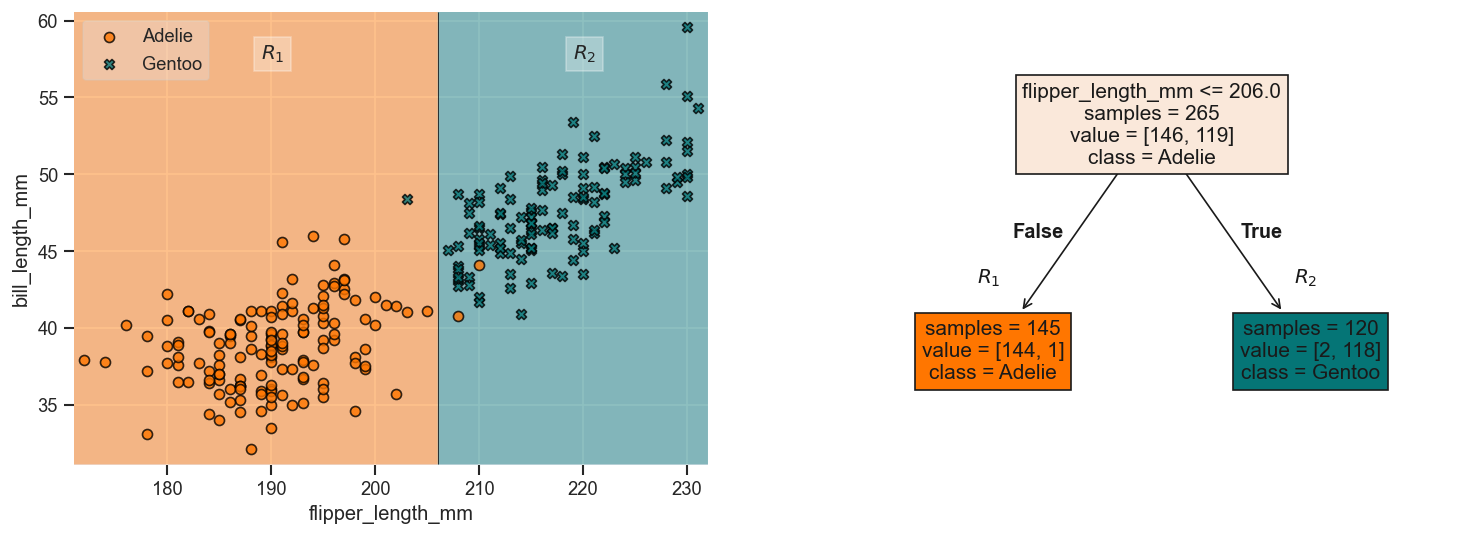

In [10]:
regions_tree(DT_g1, datasets['flbl']['X'], datasets['flbl']['y'], 
             datasets['flbl']['feats'], datasets['flbl']['class'], 
             l_labels, r_labels, tp_labels)

__Extra: `dtreeviz`__

Heres an additional visualisation package with extra features such as bein able to follow the path of a hypothetical test sample. 

I don't use `dtreeviz` in the lectures, as it can be a bit of a hassle to setup. However you may also find this a useful way of thinking about the splitting.

__Notes__

- _"For classifiers, however, the target is a category, rather than a number, so we chose to illustrate feature-target space using histograms as an indicator of feature space distributions."_ https://explained.ai/decision-tree-viz/index.html

In [11]:
from re import search

# Change to True if you want to run the dtreeviz code
DTREEVIS = True

if DTREEVIS:
    if not search("graphviz", os.environ.get('PATH')):
        # CHANGE THIS TO WHERE graphviz IS ON YOUR COMPUTER!
        GRAPHVIS_PATH = 'C:\\Program Files\\Graphviz\\bin'
        #C:\Users\delliot2\.conda\envs\mlp\Lib\site-packages\graphviz
        os.environ["PATH"] += os.pathsep + GRAPHVIS_PATH
        
    from dtreeviz.trees import dtreeviz
    DT_g1.fit(datasets['flbl']['X'], datasets['flbl']['y'])

    viz = dtreeviz(DT_g1, datasets['flbl']['X'], datasets['flbl']['y'],
                   feature_names=datasets['flbl']['feats'],
                   class_names=['Adelie', 'Gentoo'],
                   orientation ='LR', colors = col_dict, scale=2.0
                  )
    display(viz)

We can make the tree _"deeper"_, and therefore more complex, by setting the `max_depth = 3`.

In [13]:
DT_g3 = DecisionTreeClassifier(criterion='gini',
                               max_depth = 3,
                               random_state=42)

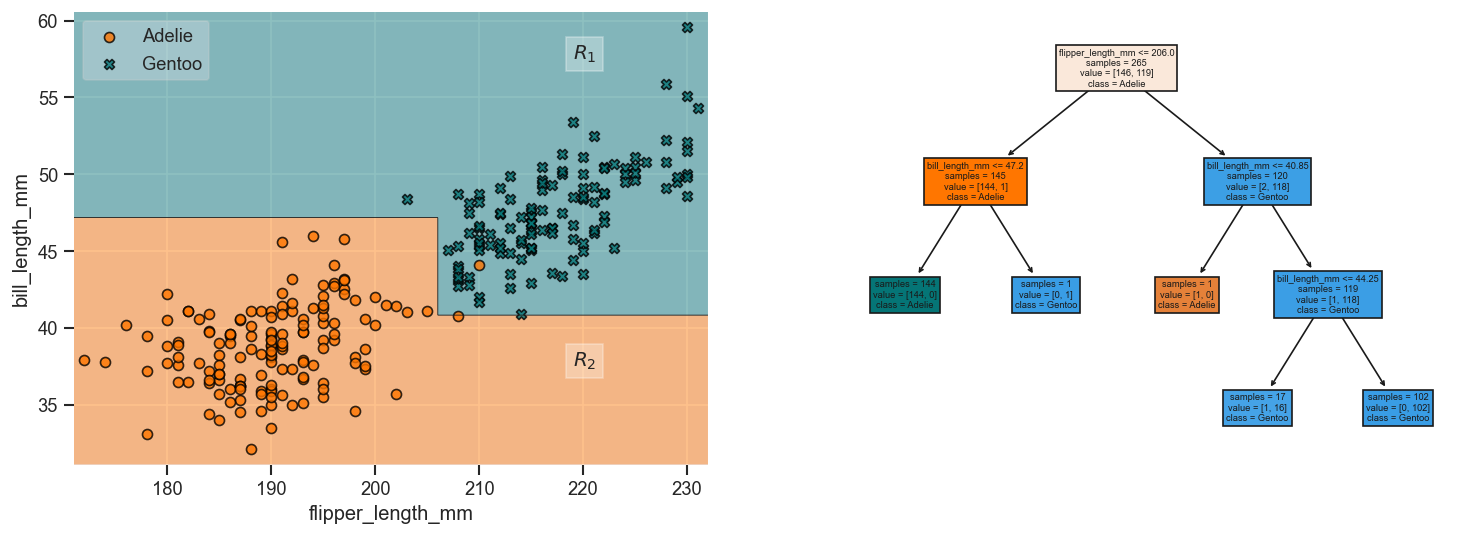

In [14]:
regions_tree(DT_g3, datasets['flbl']['X'], datasets['flbl']['y'], 
             datasets['flbl']['feats'], datasets['flbl']['class'], 
             [[219, 57.5],[219, 37.5]])

Although less accessible for plotting teh decision boundaries, we could also use more than 2 features as seen below.

__TODO__
- time allowing, do a 3d plot of the decision boundary.

In [15]:
DT_g = DecisionTreeClassifier(criterion='gini',
                               random_state=42)
DT_g.fit(datasets['bin']['X'], datasets['bin']['y'])

DecisionTreeClassifier(random_state=42)

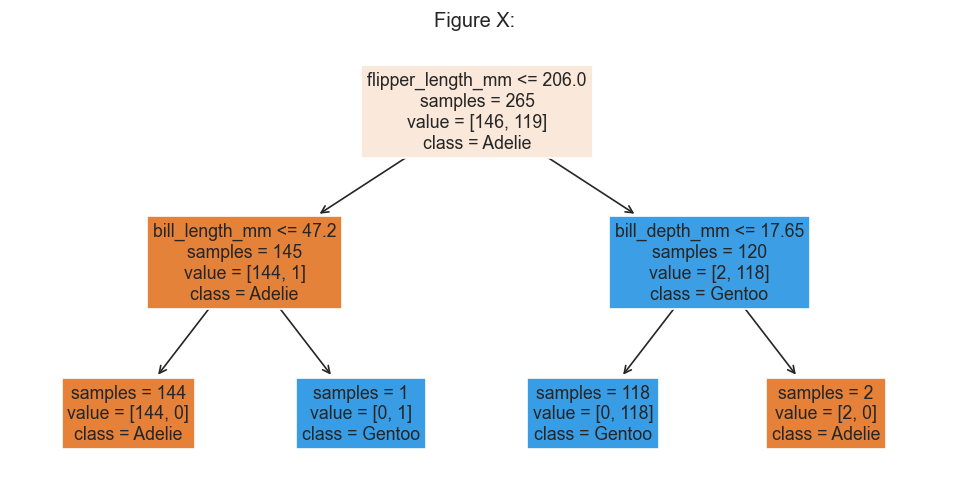

In [16]:
fig, axes = plt.subplots(figsize=(10, 5))
tree.plot_tree(DT_g,
                    feature_names=datasets['bin']['feats'], 
                    class_names=datasets['bin']['class'],
                    filled = True,
                   impurity = False,
               ax=axes
              )
plt.title("Figure X: ")
plt.savefig(os.path.join(image_dir, "figurex.png"))
plt.show()

We could also also easily extend this to have more than a 2 (binary) class labels.

In [17]:
DT_g = DecisionTreeClassifier(criterion='gini',
                               random_state=42)
DT_g.fit(datasets['multi']['X'], datasets['multi']['y'])

DecisionTreeClassifier(random_state=42)

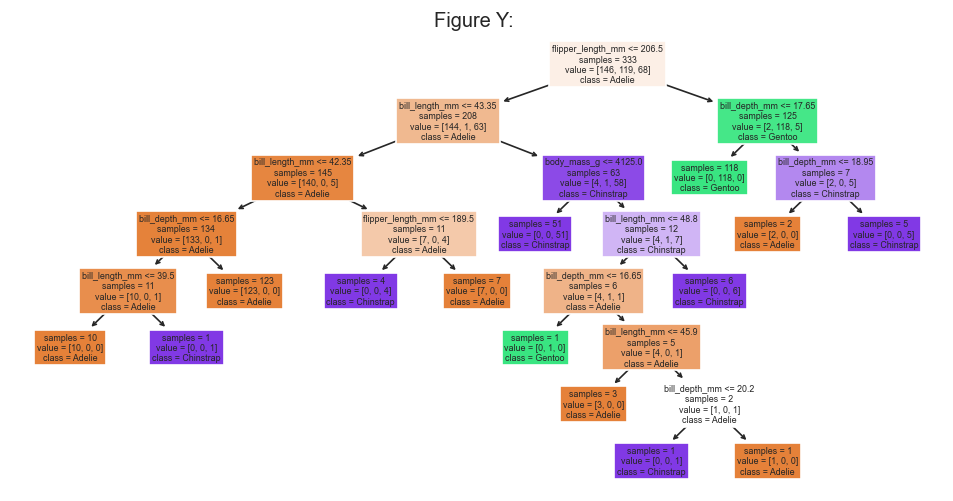

In [18]:
fig, axes = plt.subplots(figsize=(10, 5))
tree.plot_tree(DT_g,
                    feature_names=datasets['multi']['feats'], 
                    class_names=datasets['multi']['class'],
                    filled = True,
                   impurity = False,
               ax=axes
              )
plt.title("Figure Y: ")
plt.savefig(os.path.join(image_dir, "figurey.png"))
plt.show()

In a general sense this approach is pretty simple, however there are a number of design choices and considerations we have to make including<sup>5</sup>:
- How do we decide which features to select for splitting a parent node into child nodes?
- How do we decide where to split features?
- When do we stop growing a tree?
- How do we make predictions if no attributes exist to perfectly separate non-pure nodes further?

# 1.4. Dataset Example: X <a id='data2'></a>


__TODO__
- Introduce a more complex dataset because some of the examples aren't very good with the penguins

# 1.5. Specific Decision Tree Algorithms <a id='spec'></a>

Most decision tree algorithms address the following implimentation choices differently<sup>5</sup>:
- __Splitting Criterion:__ Information gain, statistical tests, objective function, etc.
- __Number of Splits:__ Binary or multi-way
- __Variables:__ Discrete vs. Continuous
- __Pruning__: Pre- vs. Post-pruning

There are a number of decision tree algorithms, prominant ones include:
- Iterative Dichotomizer 3 (ID3)
- C4.5
- __CART__

__Notes__

- Binary means _nodes_ always have two children

## CART

Scikit-Learn uses the Classification And Regression Tree (CART) algorithm.

- __Splitting Criterion:__ Information gain
- __Number of Splits:__ Binary
- __Independent Variables (Features):__ Continuous
- __Dependent variable__: Continuous or Categorical
- __Pruning__: Pre- & Post-pruning

__Notes__

- _"scikit-learn uses an optimised version of the CART algorithm; however, scikit-learn implementation does not support categorical variables for now."_ https://scikit-learn.org/stable/modules/tree.html

## Information Gain

An algorithm starts at a tree root and then splits the data based on the features that gives the largest information gain. 

To split using information gain relies on calculating the difference between an impurity measure of a parent node and the sum of the impurities of its child nodes; information gain being high when impurity of the child nodes is low. 

Three impurity measures that are commonly used in binary decision trees are the _classification error_, _gini impurity_, and _entropy_<sup>1</sup>. 

---
1. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

### Classification Error

This is simply the fraction of the training observations in a region that does not belong to the most common class:

$E = 1 - \substack{max\\k}(\hat p_{mk})$.

$\hat p_{mk}$ here is the proportion of training observations in the $m$th region that are from the $k$th class.

---
James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

__Notes__
- However this is rarely used in practice because geni index or entropy are better.. its not even an option in scikit-learn

### Gini Impurity
Measures the total variance across $K$ classes,

$G = \sum^K_{k=1}\hat p_{mk}(1-\hat p_{mk})$.

It is a measure of node _"purity"_ as a small value indicates a node contains predominantly overvations from a single class.

---
James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.

__Notes__

- It takes a small value if all of the $\hat p_{mk}$'s are close to 0 or 1

### Entropy Impurity
Entropy is an alternative measurement, given by

$D = -\sum^K_{k=1}\hat p_{mk}log \hat p_{mk}$.

Entropy will take on a value near 0 if the $\hat p_{mk}$'s are all near 0 or 1, therefore will take on a small value if the $m$th node is pure.

__Notes__

- In binary classification, entropy reaches its minimum (0) when all examples in a given node have the same label; on the other hand, the entropy is at its maximum of 1 when exactly one-half of examples a node are labeled with 1which would be useless for classification.<sup>6</sup>

In [19]:
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions
from sklearn import tree

DT_g1 = DecisionTreeClassifier(criterion='gini',
                               max_depth = 1,
                               random_state=42)

l_labels = [[189, 57.5],[219, 57.5]]
r_labels = [[0.225, 0.4],[0.725, 0.4]]
tp_labels = [[0.28, 0.5],[0.64, 0.5]]

def regions_tree(DT, X, y, feature_names, class_names, l_label_pos=None, r_label_pos=None, tp_label_pos=None, impurity = False):
    DT.fit(X,y)

    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
    plt.sca(axes[0])

    scatter_kwargs = {"c":col_dict, "marker":shape_dict}
    ax = plot_decision_regions(X, y, clf = DT,
                               markers = [shape_dict["Adelie"], shape_dict["Gentoo"]],
                               colors = col_dict["Adelie"]+","+col_dict["Gentoo"]
                              )

    handles, labels = ax.get_legend_handles_labels()
    
    if l_label_pos:
        plt.text(l_label_pos[0][0], l_label_pos[0][1], "$R_1$", bbox=dict(facecolor='white', alpha=0.3))
        plt.text(l_label_pos[1][0], l_label_pos[1][1], "$R_2$", bbox=dict(facecolor='white', alpha=0.3))
    
    ax.legend(handles, 
              class_names, 
              framealpha=0.3, scatterpoints=1)

    plt.xlabel(feature_names[0]) 
    plt.ylabel(feature_names[1])
    with plt.style.context("classic"):
        plt.sca(axes[1])
        tp = tree.plot_tree(DT,
                       feature_names=feature_names, 
                       class_names=class_names,
                       filled = True,
                           impurity = impurity)
        if r_label_pos:
            axes[1].text(r_label_pos[0][0], r_label_pos[0][1],
                         "$R_1$")
            axes[1].text(r_label_pos[1][0], r_label_pos[1][1], 
                         "$R_2$")
            
        if tp_label_pos:
            axes[1].text(tp_label_pos[0][0], tp_label_pos[0][1],
                         "False", {'fontweight':'bold'})
            axes[1].text(tp_label_pos[1][0], tp_label_pos[1][1], 
                         "True", {'fontweight':'bold'})
        
        tp[1].set_backgroundcolor(col_dict["Adelie"])
        tp[2].set_backgroundcolor(col_dict["Gentoo"])

    plt.show()

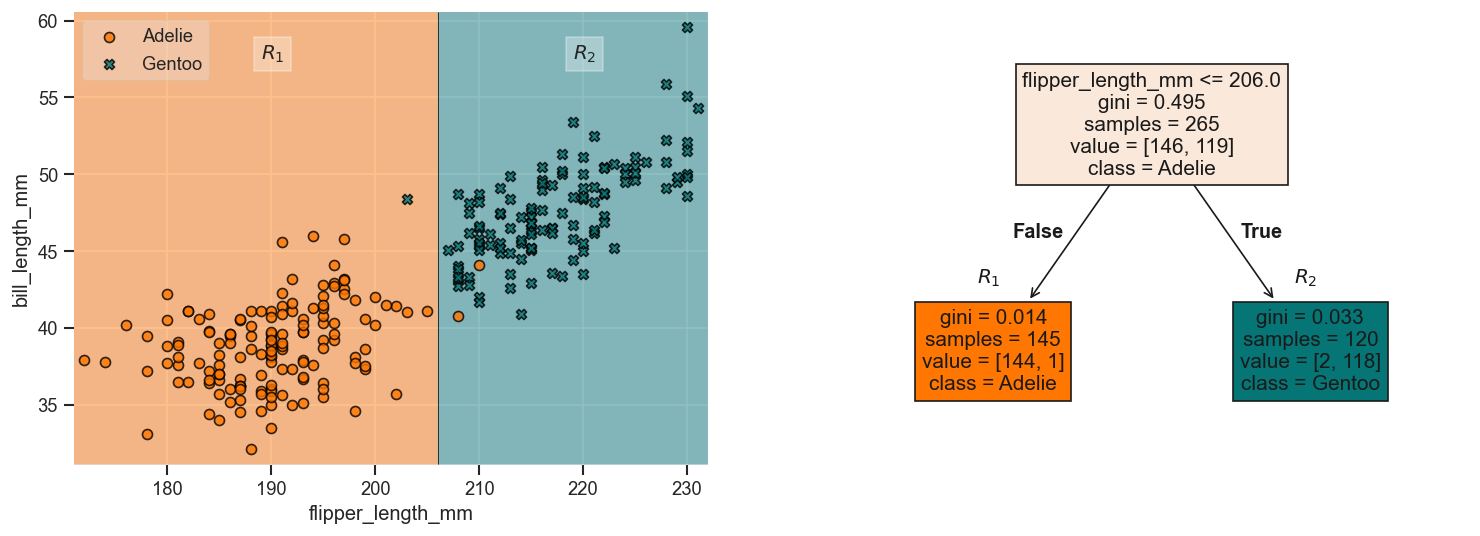

In [20]:
regions_tree(DT_g1, datasets['flbl']['X'], datasets['flbl']['y'], 
             datasets['flbl']['feats'], datasets['flbl']['class'], 
             l_labels, r_labels, tp_labels, impurity = True)

## Pruning
__Question:__ _When do we stop growing a tree?_

_"If decision trees are not pruned, they have a high risk to overfit the training data to a high degree."_ https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__notes.pdf

_"Occam’s razor: Favor a simpler hypothesis, because a simpler hypothesis that fits the data equally well (let’s say the same accuracy) is more likely or plausible than a complex one"_ https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__notes.pdf

_"A general approach for minimizing overfitting in decision trees is decision tree pruning. There are generally two approaches: post- and pre-pruning"_ https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__notes.pdf

A limit on nodes, or tree depth, is often set to avoid overfitting due to a deep tree<sup>2</sup>. 

---
2. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.

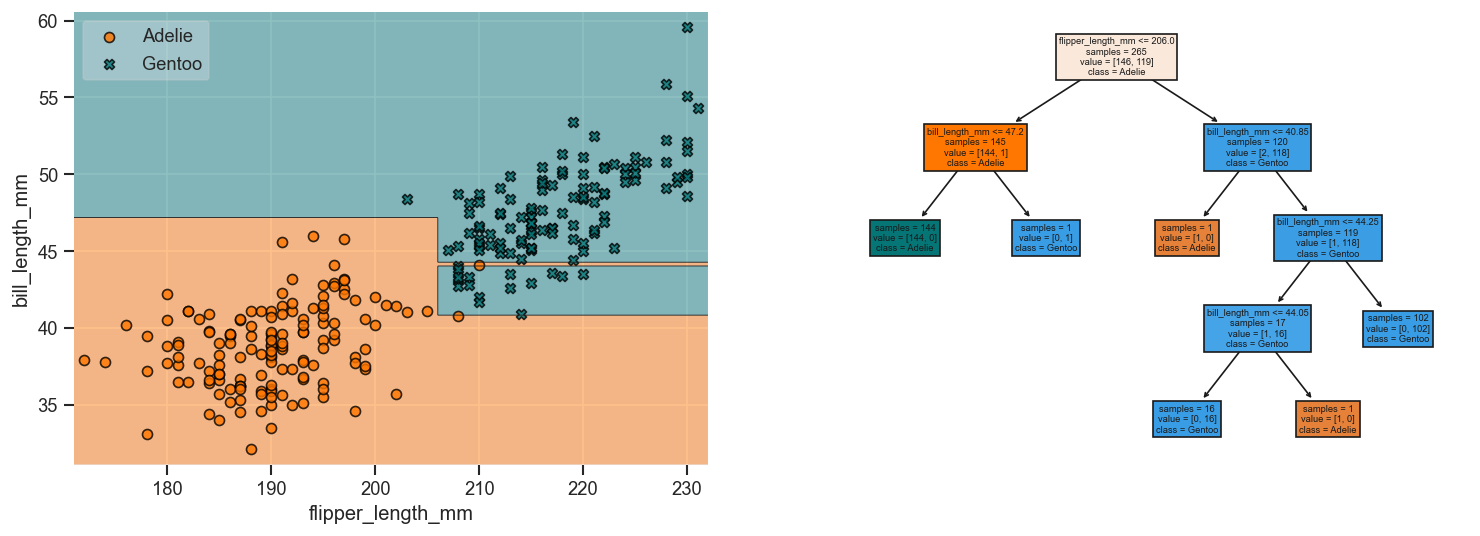

In [21]:
regions_tree(DT_g, datasets['flbl']['X'], datasets['flbl']['y'], datasets['flbl']['feats'], datasets['flbl']['class'])

### Pre-Pruning

- _"Set a depth cut-off (maximum tree depth) a priori._
- _Stop growing if a split is not statistically significant (e.g., $\chi^2$ test)._
- _Set a minimum number of data points for each node."_

https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__notes.pdf

### Post-Pruning
- _"Grow full tree first, then remove nodes (e.g., done in C4.5)._
- _Reduced-error pruning: Greedily remove nodes based on validation set performance; generally improves performance but can be problematic for limited data set sizes._
- _Cost-complexity pruning: $I + \alpha|N|$, where $I$ is an impurity measure, $\alpha$ is a tuning parameter, and $|N|$ is the total number of nodes._

https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__notes.pdf

_"Pruning consists of going back through the tree once it has been create and removing branches that don't contribute significantly enough to the errorreduction by replacing them with leaf nodes"_ 100 pg. ML book

__TODO__
- Explain "Cost-complexity pruning" better... also this dataset is not good for visualising this!

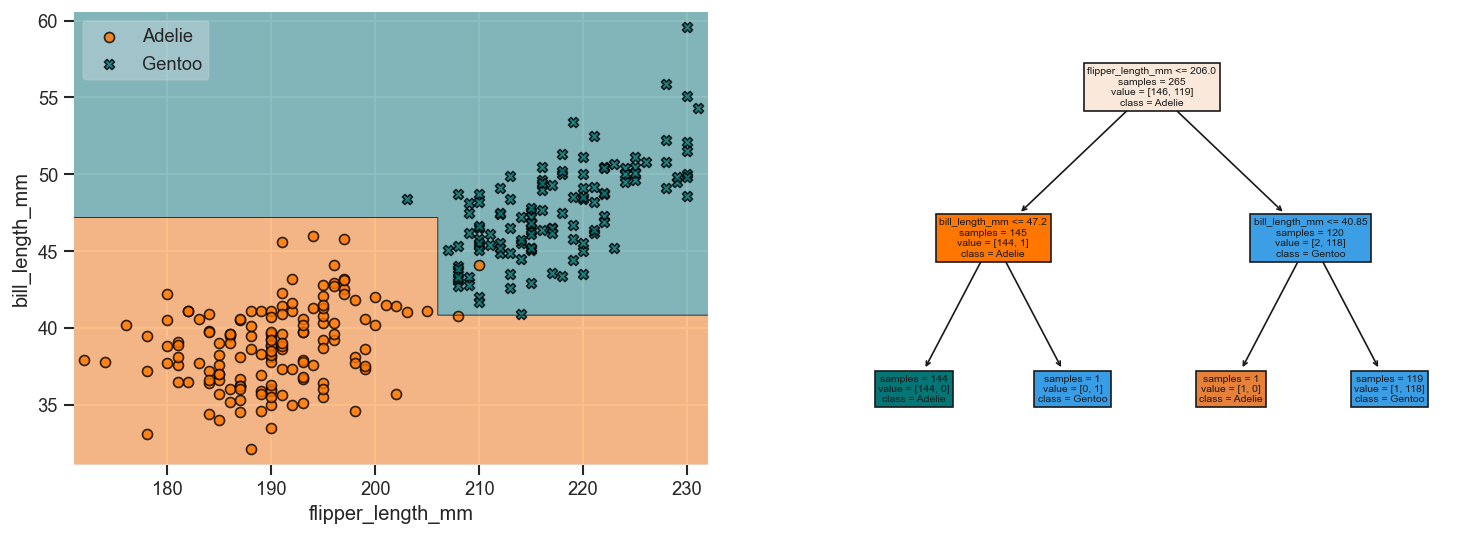

In [22]:
DT_ccp = DecisionTreeClassifier(criterion='gini',
                               max_depth = 3,
                               random_state=42,
                               ccp_alpha = 0.005                            
                              )
regions_tree(DT_ccp, datasets['flbl']['X'], datasets['flbl']['y'], datasets['flbl']['feats'], datasets['flbl']['class'])

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3372629756203174


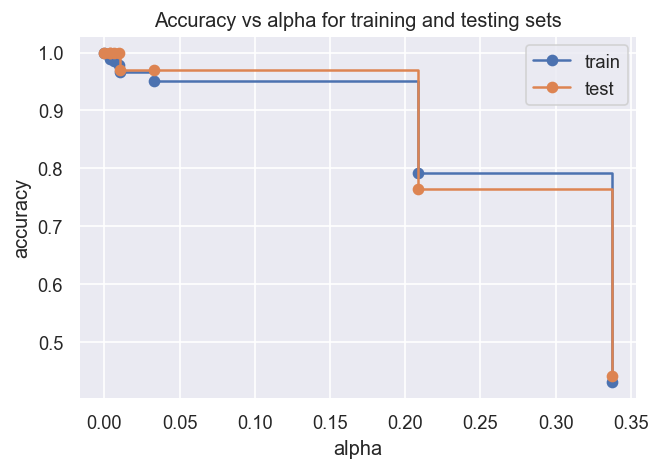

In [23]:
# https://github.com/krishnaik06/Post_Pruning_DecisionTre/blob/master/plot_cost_complexity_pruning.ipynb
X_train, X_test, y_train, y_test = train_test_split(datasets['multi']['X'] , datasets['multi']['y'],
                                                    test_size = 0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size = 0.1, random_state=42)


DT = DecisionTreeClassifier(criterion='gini',
                            random_state=42)
path = DT.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))


train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

__TODO__
- Fix the below example to include the pruning

<AxesSubplot:xlabel='Depth', ylabel='score'>

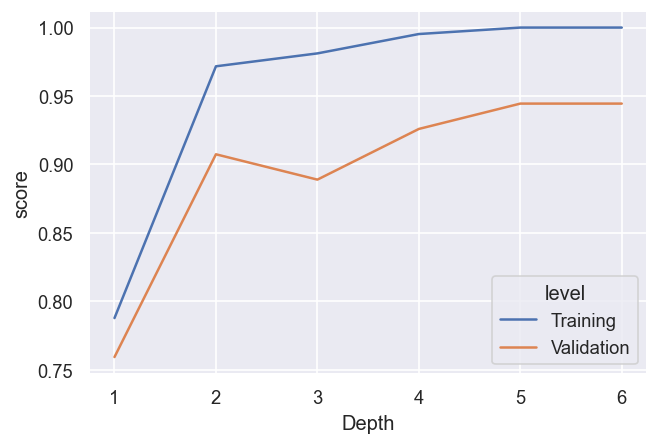

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(datasets['multi']['X'] , datasets['multi']['y'],
                                                    test_size = 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size = 0.2, random_state=42)
scores_df = pd.DataFrame()
for depth in range(1,7):
    DT = DecisionTreeClassifier(criterion='gini',
                           max_depth = depth,
                           random_state=42).fit(X_train, y_train)
    train_score = accuracy_score(y_train, DT.predict(X_train))
    val_score = accuracy_score(y_val, DT.predict(X_val))
    depth_df = pd.DataFrame([depth, train_score, val_score], index = ["Depth", "Training", 'Validation'])
    
    if depth == 1:
        scores_df = depth_df
    else:
        scores_df = pd.concat([scores_df, depth_df], axis=1)
        
scores_df = scores_df.T
scores_df = pd.pivot(scores_df, values=['Training','Validation'],
                    columns=['Depth']).T.reset_index()

scores_df.columns = ['level', 'Depth', 'score']

sns.lineplot(data = scores_df, x='Depth', y = 'score', hue = 'level')

### Extra: Other Algorithms

__ID3__

- __Splitting Criterion:__ Information gain
- __Number of Splits:__ Binary
- __Variables:__ Continuous?
- __Pruning__: ?

See pgs.27-30 of Burkov (2019)

__C4.5__

- __Splitting Criterion:__ Information gain
- __Number of Splits:__ Binary
- __Variables:__ Continuous & Discrete
- __Pruning__: Post-Pruning

# Associated Exercises

Now might be a good time to try exercises X-X.

# References
1. James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. An introduction to statistical learning. Vol. 112. New York: springer, 2013.
2. Gorman KB, Williams TD, Fraser WR (2014). Ecological sexual dimorphism and environmental variability within a community of Antarctic penguins (genus Pygoscelis). PLoS ONE 9(3):e90081. https://doi.org/10.1371/journal.pone.0090081
3. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
4. Raschka, Sebastian, and Vahid Mirjalili. Python Machine Learning, 2nd Ed. Packt Publishing, 2017.
5. https://github.com/rasbt/stat479-machine-learning-fs19/blob/master/06_trees/06-trees__notes.pdf
6. Burkov, A. (2019). The hundred-page machine learning book (Vol. 1). Canada: Andriy Burkov.

In [18]:
!jupyter nbconvert 1_Decision_Trees.ipynb \
    --to slides \
    --output-dir . \
    --TemplateExporter.exclude_input=True \
    --TemplateExporter.exclude_output_prompt=True \
    --SlidesExporter.reveal_scroll=True

[NbConvertApp] Converting notebook 1_Decision_Trees.ipynb to slides
[NbConvertApp] Writing 3713734 bytes to 1_Decision_Trees.slides.html
